In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import random

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    KFoldData = []
    num_of_data = x_train.shape[0]
    # Get all training data's indices and shuffle the ordering
    data_indices = np.arange(num_of_data)
    random.shuffle(data_indices)

    if num_of_data % k == 0:
        # Create k splits to become validation folds
        valFolds = np.split(data_indices, k, axis=0)
        for i in range(k):
            currentSplit = []
            val_fold = np.sort(valFolds[i])
            train_fold = np.setdiff1d(data_indices, val_fold)
            currentSplit.append(train_fold)
            currentSplit.append(val_fold)
            KFoldData.append(currentSplit)
    else:
        """
        When num_of_data is not divisible by K:
        The first (n_samples % n_splits) folds have size (n_samples // n_splits + 1),
        other folds have size (n_samples // n_splits), where n_samples is the number of samples.
        """
        num_of_firstValFolds = num_of_data % k
        num_of_otherValFolds = k - num_of_firstValFolds
        size_of_each_firstValFold = num_of_data // k + 1
        size_of_each_otherValFold = num_of_data // k
        data_of_firstValFolds = data_indices[:num_of_firstValFolds*size_of_each_firstValFold]
        data_of_otherValFolds = np.setdiff1d(data_indices, data_of_firstValFolds)

        # For first parts
        firstValFolds = np.split(data_of_firstValFolds, num_of_firstValFolds, axis=0)
        for i in range(num_of_firstValFolds):
            currentSplit = []
            val_fold = np.sort(firstValFolds[i])
            train_fold = np.setdiff1d(data_of_firstValFolds, val_fold)
            currentSplit.append(train_fold)
            currentSplit.append(val_fold)
            KFoldData.append(currentSplit)

        # For other parts
        otherValFolds = np.split(data_of_otherValFolds, num_of_otherValFolds, axis=0)
        for i in range(num_of_otherValFolds):
            currentSplit = []
            val_fold = np.sort(otherValFolds[i])
            train_fold = np.setdiff1d(data_of_otherValFolds, val_fold)
            currentSplit.append(train_fold)
            currentSplit.append(val_fold)
            KFoldData.append(currentSplit)

    return KFoldData

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

In [7]:
# Show validation fold of each split
tmp = []
for i in range(len(kfold_data)):
    print(f'Split {i}')
    print('Training index:')
    print(kfold_data[i][0])
    print('Validation index:')
    print(kfold_data[i][1])
    print('\n')

Split 0
Training index:
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  23  24  26  27  28  29  30  31  32  33  34  35  36  37  38
  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  70  71  72  73  74  75  76  77
  78  79  80  82  83  84  85  87  88  89  91  92  93  94  95  96  97  98
  99 100 101 102 103 105 106 108 109 110 111 112 113 114 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 133 134 135 136 138 140
 141 143 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 181 182 183 184 185 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 205 206 207 208 209 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 248 249 250 251 253 254 255 256
 257 258 259 260 261 262 26

## example

In [8]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data_example= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data_example.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  3  5  6  7  8  9 10 11 14 15 17 18 19], Validation index: [ 4 12 13 16]
Split: 2, Training index: [ 0  1  4  5  7  8  9 11 12 13 14 15 16 17 18 19], Validation index: [ 2  3  6 10]
Split: 3, Training index: [ 0  1  2  3  4  5  6  7 10 12 13 14 15 16 17 18], Validation index: [ 8  9 11 19]
Split: 4, Training index: [ 0  1  2  3  4  6  8  9 10 11 12 13 14 15 16 19], Validation index: [ 5  7 17 18]
Split: 5, Training index: [ 2  3  4  5  6  7  8  9 10 11 12 13 16 17 18 19], Validation index: [ 0  1 14 15]


In [9]:
assert len(kfold_data_example) == 5 # should contain 5 fold of data
assert len(kfold_data_example[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data_example[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [10]:
def getDataFromFold(x_train, y_train, each_fold):
    """ Get data of each Training fold and Validation fold """
    # For training fold
    indices = each_fold[0]
    x_train_subset = x_train[np.ix_(indices)]
    y_train_subset = y_train[np.ix_(indices)]

    # For validation fold
    indices = each_fold[1]
    x_val = x_train[np.ix_(indices)]
    y_val = y_train[np.ix_(indices)]

    return x_train_subset, y_train_subset, x_val, y_val

In [11]:
def runCrossValidation_SVC(c, gamma, kfold_data):
    """ k-fold Cross Validation """
    k = len(kfold_data)
    total_score = 0

    for i in range(k):
        x_train_subset, y_train_subset, x_val, y_val = getDataFromFold(x_train, y_train, kfold_data[i])
        clf = SVC(C=c, kernel='rbf', gamma=gamma)
        clf.fit(x_train_subset, y_train_subset)
        y_pred = clf.predict(x_val)
        current_accuracy = accuracy_score(y_pred, y_val)
        # print(f'(C:{c}, gamma:{gamma} -> accuracy:{current_accuracy})')
        total_score += current_accuracy
    return total_score / k

In [12]:
""" Grid search to find the best C and gamma """
C_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
Gamma_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
accuracy_list = []
best_accuracy = 0.0
best_C, best_gamma = None, None

for c in C_list:
    for gamma in Gamma_list:
        # For current hyperparameter setting, run cross validation and get the average score
        avg_accuracy = runCrossValidation_SVC(c, gamma, kfold_data)
        # print(f'====== average score of hyp[C:{c}, gamma:{gamma}] -> {avg_accuracy} ======')
        accuracy_list.append(avg_accuracy)

        if(best_accuracy < avg_accuracy):
            best_accuracy = avg_accuracy
            best_C = c
            best_gamma = gamma

# Transform the accuracy list to ndarray (for plotting heatmap)
accuracy_arr = np.array(accuracy_list).reshape(len(C_list), len(Gamma_list))

In [13]:
print('best_accuracy:', best_accuracy)
print(f'best_parameters: [C:{best_C}, gamma:{best_gamma}]')

best_accuracy: 0.8854545454545454
best_parameters: [C:10.0, gamma:0.001]


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

Text(0.5, 1.0, 'Hyperparameter GridSearch')

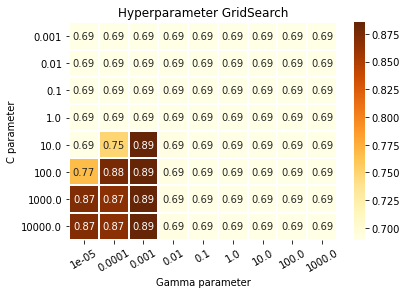

In [14]:
""" Plot the heatmap of Grid Search (color: average score of validation folds)"""
import matplotlib as plt
import seaborn as sns

ax = sns.heatmap(accuracy_arr, annot=True, fmt=".2f", cmap="YlOrBr", linewidths=1, linecolor='white')
ax.set_xticklabels(Gamma_list, rotation=30)
ax.set_yticklabels(C_list, rotation=0)
ax.set(xlabel='Gamma parameter', ylabel='C parameter')
ax.set_title("Hyperparameter GridSearch")

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [15]:
""" Perform SVM Classification on whole training set based on the best hyperparameters we just found """
best_model = SVC(C=best_C, kernel='rbf', gamma=best_gamma)
best_model.fit(x_train, y_train)

SVC(C=10.0, gamma=0.001)

In [16]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of the model you have implemented in HW1 with the SVM

### HW1

In [17]:
train_df = pd.read_csv("../PR_HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1,1)
y_train = train_df['y_train'].to_numpy().reshape(-1,1)

test_df = pd.read_csv("../PR_HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1,1)
y_test = test_df['y_test'].to_numpy().reshape(-1,1)

In [18]:
kfold_data = cross_validation(x_train, y_train, k=5)

In [19]:
def runCrossValidation_SVR(c, gamma, kfold_data):
    """ k-fold Cross Validation for SVR """
    k = len(kfold_data)
    total_error = 0

    for i in range(k):
        x_train_subset, y_train_subset, x_val, y_val = getDataFromFold(x_train, y_train, kfold_data[i])
        clf = SVR(C=c, kernel='rbf', gamma=gamma)
        clf.fit(x_train_subset, y_train_subset.ravel())
        y_pred = clf.predict(x_val)

        # Calculate the mean square error
        y_pred = y_pred.reshape(-1, 1)
        current_error = np.square(np.subtract(y_pred, y_val)).mean()
        # print(f'(C:{c}, gamma:{gamma} -> error:{current_error})')

        total_error += current_error
    return total_error / k

In [20]:
""" Grid search to find the best C and gamma """
C_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
Gamma_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
error_list = []
best_error = float("inf")
best_C, best_gamma = None, None

for c in C_list:
    for gamma in Gamma_list:
        # For current hyperparameter setting, run cross validation and get the average error
        avg_error = runCrossValidation_SVR(c, gamma, kfold_data)
        # print(f'====== average square error of hyp[C:{c}, gamma:{gamma}] -> {avg_error} ======')
        error_list.append(avg_error)

        if(best_error > avg_error):
            best_error = avg_error
            best_C = c
            best_gamma = gamma

# Transform the error list to ndarray (for plotting heatmap)
error_arr = np.array(error_list).reshape(len(C_list), len(Gamma_list))

In [21]:
print('best_error:', best_error)
print(f'best_parameters: [C:{best_C}, gamma:{best_gamma}]')

best_error: 0.47425793647160586
best_parameters: [C:1000.0, gamma:0.0001]


Text(0.5, 1.0, 'Hyperparameter GridSearch')

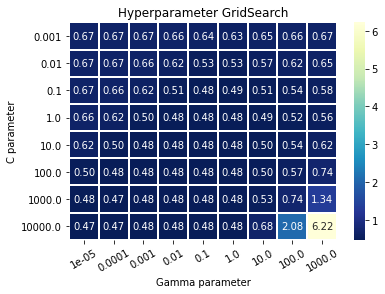

In [22]:
""" Plot the heatmap of Grid Search (color: average error of validation folds)"""
import matplotlib as plt
import seaborn as sns

ax = sns.heatmap(error_arr, annot=True, fmt=".2f", cmap="YlGnBu_r", linewidths=1, linecolor='white')
ax.set_xticklabels(Gamma_list, rotation=30)
ax.set_yticklabels(C_list, rotation=0)
ax.set(xlabel='Gamma parameter', ylabel='C parameter')
ax.set_title("Hyperparameter GridSearch")

In [23]:
""" Perform SVM Regression on whole training set based on the best hyperparameters we just found """
clf = SVR(C=best_C, kernel='rbf', gamma=best_gamma)
clf.fit(x_train, y_train.ravel())

SVR(C=1000.0, gamma=0.0001)

In [24]:
""" Evalulate the result SVM Regression model with test data """
y_pred = clf.predict(x_test)
y_pred = y_pred.reshape(-1, 1)  # need to reshape before calculating MSE
MSE_bySVM = np.square(np.subtract(y_test, y_pred)).mean()

In [25]:
print("Mean Square error of Linear regression: 0.4909025641183266")  # The value is copied from my HW1
print("Mean Square error of SVM regresssion model:", MSE_bySVM)

Mean Square error of Linear regression: 0.4909025641183266
Mean Square error of SVM regresssion model: 0.49356689810073456
